#### Basic Classification

The following notebook performs classification analysis using a variety of machine learning algorithms.The algorithms are trained using known income levels and personal characteristics of a population. After som data cleaning and exploration, a subset of features are extracted and used as the predictors in four different machine learning algorithms. The models are used to predict the income bracket of a person based on input characteristics.

The purpose is to explore the accuracy of various models and to perform tuning of the models to improve accuracy.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sklearn as skl
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
import sklearn.metrics as metrics 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold
import math

%matplotlib inline
%load_ext autotime
#%unload_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 52 ms


In [8]:
#Learning Curve Plot
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

time: 72 ms


## 0. Read in Files

In [9]:
# Read in Training Data
training = pd.read_csv("income-training.csv")

time: 96 ms


In [10]:
# Read in Testing Data
testing = pd.read_csv("income-testing.csv")

time: 72 ms


In [11]:
#View the Data
training

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K
5,35,Private,261241,HS-grad,9,Divorced,Transport-moving,Not-in-family,White,Male,0,1741,60,United-States,<50K
6,51,Private,200576,Bachelors,13,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<50K
7,43,Self-emp-inc,175715,HS-grad,9,Never-married,Exec-managerial,Not-in-family,Black,Male,0,0,55,United-States,<50K
8,29,State-gov,188986,Assoc-voc,11,Never-married,Tech-support,Not-in-family,White,Female,0,1590,64,United-States,<50K
9,65,NaN,137354,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,20,United-States,<50K


time: 160 ms


In [12]:
#Convert Income Bracket to Category 
training['IncomeBracket'] = training['IncomeBracket'].astype('category')
testing['IncomeBracket'] = testing['IncomeBracket'].astype('category')

#View The Data Info
print(training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 15 columns):
Age              24421 non-null int64
WorkClass        23037 non-null object
FinalWeight      24421 non-null int64
Education        24421 non-null object
EducationLvl     24421 non-null int64
MaritalStatus    24421 non-null object
Occupation       23031 non-null object
Relationship     24421 non-null object
Race             24421 non-null object
Sex              24421 non-null object
CapitalGain      24421 non-null int64
CapitalLoss      24421 non-null int64
HoursPerWeek     24421 non-null int64
NativeCountry    24026 non-null object
IncomeBracket    24421 non-null category
dtypes: category(1), int64(6), object(8)
memory usage: 2.6+ MB
None
time: 56 ms


## 1. Data Cleaning

#### Dealing with Missing Data

In [13]:
#Assess Missing Data
print('\nNumber of Missing Values Per Category')
print(training.isnull().sum())

#Check Impact of Removing Missing Data per Category
print('\nNaN Ratio for Each Category with Missing Values')
print('Working Class NaN Ratio:', training['WorkClass'].isnull().sum()/training['WorkClass'].count()*100, '%')
print('Occupation NaN Ratio:', training['Occupation'].isnull().sum()/training['Occupation'].count()*100, '%')
print('NativeCountry NaN Ratio:', training['NativeCountry'].isnull().sum()/training['NativeCountry'].count()*100, '%')

#Check Impact of Removing Missing Data Overall
total_nan = training['WorkClass'].isnull().sum()+training['WorkClass'].isnull().sum()
print('Overall NaN Ratio:', (training.shape[0]-training.dropna().shape[0])/training.shape[0]*100, '%')


Number of Missing Values Per Category
Age                 0
WorkClass        1384
FinalWeight         0
Education           0
EducationLvl        0
MaritalStatus       0
Occupation       1390
Relationship        0
Race                0
Sex                 0
CapitalGain         0
CapitalLoss         0
HoursPerWeek        0
NativeCountry     395
IncomeBracket       0
dtype: int64

NaN Ratio for Each Category with Missing Values
Working Class NaN Ratio: 6.00772670053 %
Occupation NaN Ratio: 6.03534366723 %
NativeCountry NaN Ratio: 1.6440522767 %
Overall NaN Ratio: 7.235575938741247 %
time: 148 ms


<u>Dicussion</u>

The number of missing values for each category with missing values is less then 6% across the three categories. Removing these rows with missing values will have a neglible affect on the training set. It appears that the WorkClass and Occupation have almost identical number of missing values. This could mean the data could belong to the same rows. Removing all the NaN values, the percentage of NaN to the total dataframe rows confirms this showing approximately 7.2% of the data has a missing value. This is close to the 6% of each of the Occupation and WorkClass missing values. 

Since only 7.2%  of the data is missing values, removing these rows will have a neglible affect. This is done below.

<b>Insight:</b> <br>
An almost identical number of missing data occurred across the Occupation and WorkClass categories. These two categories are related, for people who did not enter an occupation did not have a working class. This could just indicate that a person is not currently employed but still have income through other means. 

By excluding the entries with missing data could potentially produce a bias in the model because it does not appropriately account for people who may be unemployed but still have an income. 

In [14]:
#Remove All Rows with NaN Values
training_clean = training.dropna()
testing_clean = testing.dropna()
print('Training DataFrame Length',len(training_clean))
print('Testing DataFrame Length',len(testing_clean))

Training DataFrame Length 22654
Testing DataFrame Length 11307
time: 68 ms


#### Encoding Categorical Data

To encode the data, SKLearn has a function called LabelEncoder() which will perform the encoding task automatically. Each object column will be converted to encoded data based on how many categories are in the column, where each category is given an integer value. This encoded data is required for input into classification algorithms. The LabelEncoder() function will determine how many different categories are in each object column and cange the object data to numerical data.

Another option to use would be one-hot encoding which instead of putting the dat in a single column, could produce a new dummy variable for each category which would have it's own column. This is considered a better way to improve the machine learning results as it reduces the bias associated with columns with a hihger number of categories. Machine learning algorithms tend to associate a higher number with higher importance. One-Hot encoding produces binarized data so the average of a category is still jsut 1. 

In this case, we have small number of categories and will ignore the small level of bias and continue with using the LabelEncoder() function. 


http://pbpython.com/categorical-encoding.html

In [15]:
#Label Encoder Function
def encode_data (df):  
    # Cycle Through Each Column to Transform
    for column in df.columns:
        #Only Encode if Object Type
        if df[column].dtypes == object:
            df[column]=LabelEncoder().fit_transform(df[column])       
    return df

time: 4 ms


In [16]:
#Encode Training & Testing Sets
temp = training_clean.copy()
training_encoded = encode_data(temp)
temp = testing_clean.copy()
testing_encoded = encode_data(temp)

time: 163 ms


## 2. Exploratory Analysis


##### A. Income Bracket Distribution

An obvious start is to plot the breakdown of the income brackets. As expected, the lowest income bracket made up most of the data set. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026555CCA3C8>], dtype=object)

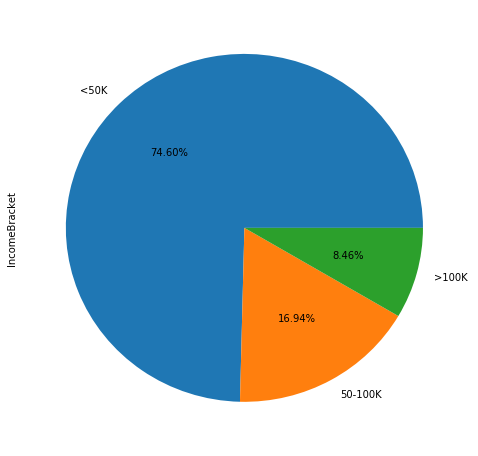

time: 426 ms


In [17]:
#Count Number of People in Each Income Bracket
income_counts = training_encoded['IncomeBracket'].value_counts()
#Plot Pie Chart of People in Each Category
income_counts.plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%.2f%%')

<u>Dicsussion</u>


##### B. Income Distribution By Occupation

From this plot we can see that spread of income across each occupation. As expected, every occupation has a signifciant number of lower bracket individuals and very few high income individuals. It is clear that the high income brackets lie within occupations related to managerial tasks and professional speciality services as would be expected as well. 

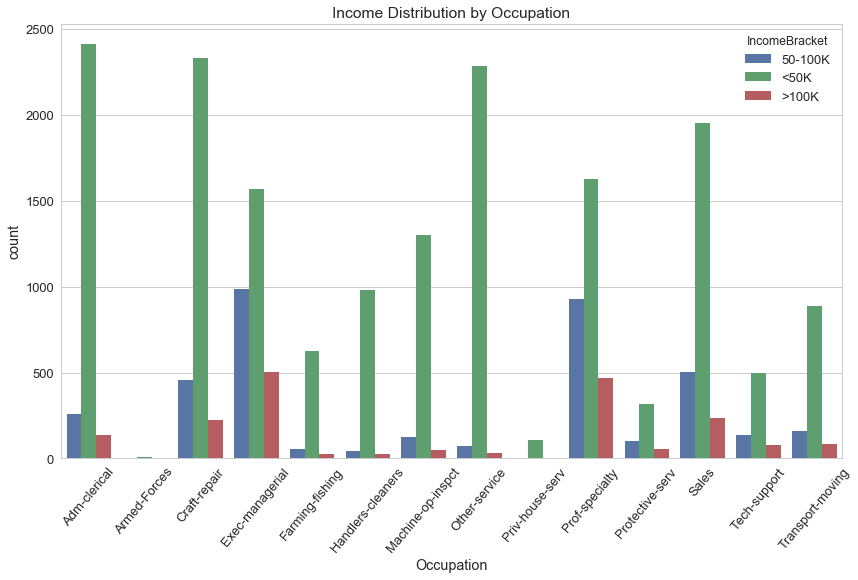

time: 469 ms


In [18]:
#Create Dataframe of Occupation and Income Categoris
inc_occ_df = training_clean[['Occupation','IncomeBracket']].sort_values(by =['Occupation'])

#Create Seaborn Nested/Multiple Count Plot
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(14,8))
cplot = sns.countplot(x="Occupation", hue="IncomeBracket", data=inc_occ_df)
cplot.set_title('Income Distribution by Occupation')

#Rotate X-Tick Labels
for item in cplot.get_xticklabels():
    item.set_rotation(50)   

#### C. Income Distribution By Education

This plot indicates that higher level brackets only occur with education levels above high school. Although an obvious trend, it does indicate that education level will be a significant contributor to classifying income brackets.

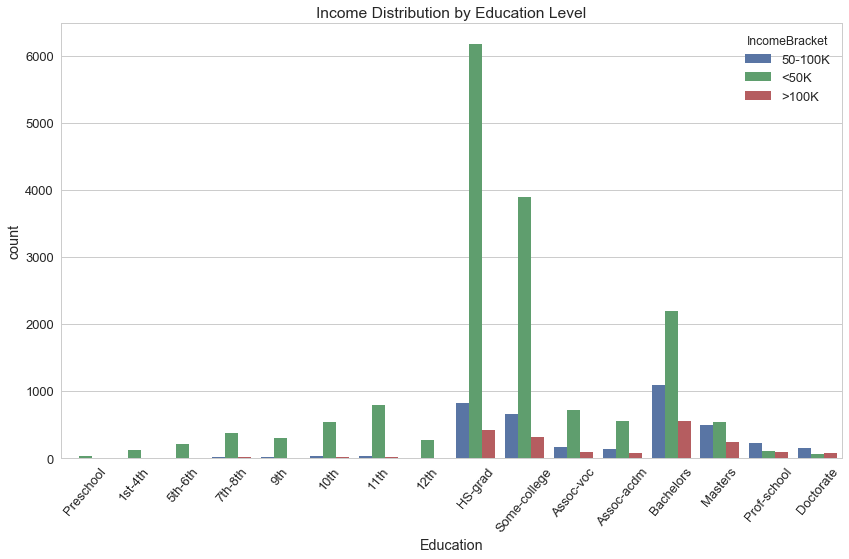

time: 520 ms


In [19]:
#Create Dataframe of Education and Income Categoris
inc_occ_df = training_clean[['Education','IncomeBracket','EducationLvl']].sort_values(by =['EducationLvl'])

#Create Seaborn Nested/Multiple Count Plot
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(14,8))
cplot = sns.countplot(x="Education", hue="IncomeBracket", data=inc_occ_df)
cplot.set_title('Income Distribution by Education Level')


#Rotate X-Tick Labels
for item in cplot.get_xticklabels():
    item.set_rotation(50) 

#### Feature Importance Visualisation

The following corrlealtion plots and are used to determine the importance of features. It is extended to include further analysis to support the claims of the correlation analysis.

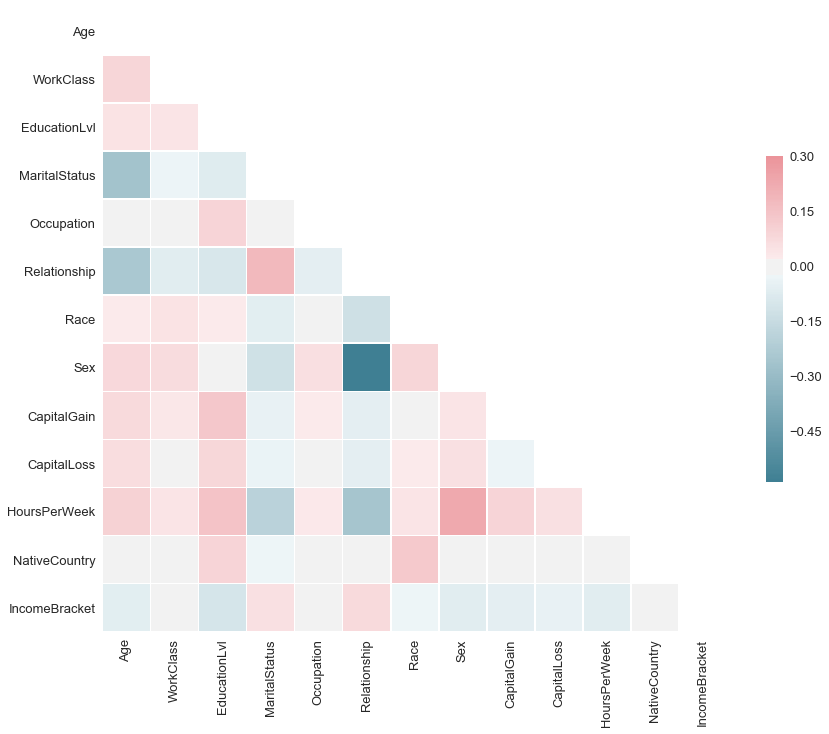

time: 597 ms


In [20]:
# Compute the correlation matrix
training_encoded['IncomeBracket'] = training_clean['IncomeBracket'].astype('object')
training_encoded2 = encode_data(training_encoded)
features = training_encoded2[['Age','WorkClass','EducationLvl','MaritalStatus','Occupation','Relationship','Race','Sex','CapitalGain','CapitalLoss','HoursPerWeek','NativeCountry','IncomeBracket']]
corr = features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

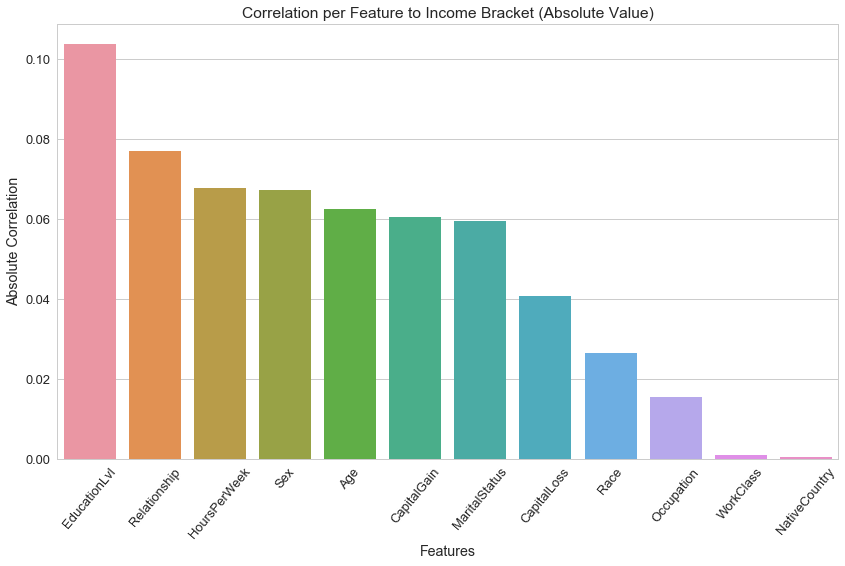

time: 288 ms


In [21]:
#Plot Absolute Correlation Values for Each Feature
abs_corr = abs(corr.iloc[0:12,12:13]).sort_values(by=['IncomeBracket'], ascending=False)

#Create Bar Plot of Feature Correlation Values
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(14,8))
bplot = sns.barplot(x=abs_corr.index, y = 'IncomeBracket',  data=abs_corr)
bplot.set(xlabel='Features', ylabel='Absolute Correlation')
bplot.set_title('Correlation per Feature to Income Bracket (Absolute Value)')

#Rotate X-Tick Labels
for item in bplot.get_xticklabels():
    item.set_rotation(50) 

<u>Discussion</u>

The correlation plot indicates that <b>Relationships</b> and <b>Marital Status</b> have the highest positive correlations with the Income Bracket. This is counterintutive as I would expect that Age, Education Level, Occupation and Working Class to have a stronger positive correlation then being indicated by this correlation plot, but it is difficult to read from the matrix. To better see the correlation strengths of each feature, the absolute value of each correlation to the Income Brakcet is plotted in a bar chart above. 

From the bar chart, it is clearly visible that education has the greatest impact, followed by relationship, hours per week, sex, age, capital gain and marital status. 

Extension:<br>
Exploration of feature selection and the Sklearn Tool kit reveals another tool for determining feature importance. This is known as Mutual Information Classification. This uses k-nearest neighbours distances. The MIC will output values for each input feature which indicate the degree at which the target is dependent on that feature. The higher the MIC number, the more important the feature. 

https://en.wikipedia.org/wiki/Feature_selection

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

#### Implement Mutual Information Classifier & Visualise

In [22]:
#Create Feature Set
feature_set = features.iloc[:,:-1]

#Create Target 
target_set = features.iloc[:,12]

#Preapre Dataframe
MIC_Output = pd.DataFrame(columns = ['Feature','MIC Value'])
MIC_Output['Feature'] = feature_set.columns

#Run Mutual Information Classifier
MIC_Output['MIC Value'] = mutual_info_classif(feature_set, target_set, n_neighbors=3, copy=True, random_state=None)

time: 3.85 s


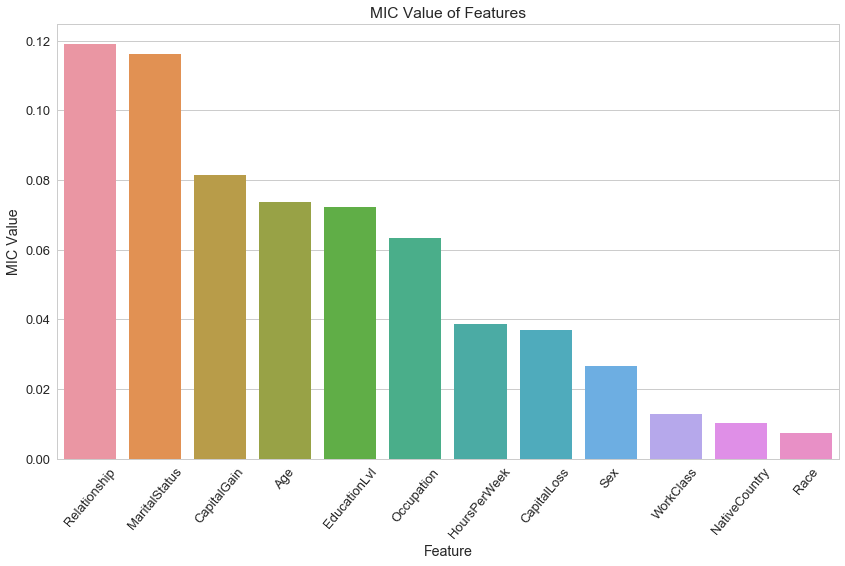

time: 384 ms


In [23]:
#Visulaize the MIC Values
MIC_Sorted = MIC_Output.sort_values(by=['MIC Value'],  ascending=False)

#Plot Bar Chart
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(14,8))
plot = sns.barplot(MIC_Sorted['Feature'], MIC_Sorted['MIC Value'])
plot.set_title('MIC Value of Features')

#Rotate X-Tick Labels
for item in plot.get_xticklabels():
    item.set_rotation(50)   

<u>Extended Dicsussion</u>

The MIC value method confirms that the <b>Relationships</b> and <b>Marital Status</b> are he strongest two features to the Income Bracket which was seen in the correlation matrix. However, the impact of features is different then the absolute correlation value plot above. This is due to the difference in handling relationships betwen variables. The correlation coefificient can only take into account linear relationships between actual variables where as the mutual information method is the distance between two distributions.  

The set of features determined by each method differ,<br>
<b>Correlation</b>: Education Level, Relationship, Hours per Week, Sex, Age, Capital Gain and Marital Status.<br>
<b>MIC Method</b>:  Relationship, Marital Status,Capital Gain, Education Level, Age, Occupation.

Using the MIC Values method as an extension creates a better understanding of the feature importance and futhermore will contirbute to feature selection. It is important to note that the Mutual Information Classification method is itself a classifier and a little further above just visualisation. 

<u>Scree Plot</u><br>
I use a scree plot below to confirm the number of features that should be used from the original set. The plot indicates 6 features should be utilized in the feature set. This aligns with the MIC method.

Text(0,0.5,'Eigenvalue')

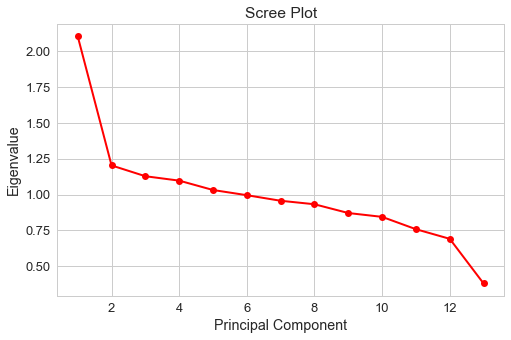

time: 183 ms


In [24]:
#Using Scree Plot to Determine Number of Features
eig_vals, eig_vecs = np.linalg.eig(corr)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

#Scree Plot
eig_vals[::-1].sort()
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(13) + 1
plt.plot(sing_vals, eig_vals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

## 3. Feature Selection

Feature engineering is useful to machine learning by reducing the computational load of the algorithms by reducing the number of features required to include in the set. The important aspect of feature engineering is to reduce the number of features while maintaining the essence of correlation between the feautures and the target and to include only the features which explain the variance in the target set. When data sets become very large and include a large number of variables then feature engineering becomes much more critical in order to have the algorithms compute as efficiently as possible.

The two feature importance methods explored above will be used to help determine the features to select for modelling.

<u>New Features</u><br>

I introduce two new features from the existing feature set. This includes a feature which collaborates Sex, Relationship and Marital Status. These three features are correlated together and all within a similar base of understanding in the real world, describing a similar topic.  The second new feature is the Net Capital feature which is the difference between a capital gain and the capital loss. This produces a single column which describes the same scenario as the two columns seperately. 

a. Sex & Relationship & Marital Status<br>
b. Net Capital = Capital Gain - Capital Loss

In [25]:
#Remove Insignificant Features
training_encoded_short = training_encoded.drop(['Race','NativeCountry','WorkClass','IncomeBracket'
                                                ,'Sex','Relationship','FinalWeight','MaritalStatus'
                                                ,'CapitalGain','CapitalLoss','Education' ], axis=1).copy()
testing_encoded_short = testing_encoded.drop(['Race','NativeCountry','WorkClass','IncomeBracket'
                                                ,'Sex','Relationship','FinalWeight','MaritalStatus'
                                                ,'CapitalGain','CapitalLoss','Education' ], axis=1).copy()

#Create New Features
training_encoded_short['Sex_Rel_Mar'] = pd.DataFrame(training_encoded["Sex"] + training_encoded['Relationship'] 
                                                     + training_encoded['MaritalStatus'])
training_encoded_short['Net_Capital'] = pd.DataFrame(training_encoded["CapitalGain"] - training_encoded['CapitalLoss'])

testing_encoded_short['Sex_Rel_Mar'] = pd.DataFrame(testing_encoded["Sex"] + testing_encoded['Relationship'] 
                                                     + testing_encoded['MaritalStatus'])
testing_encoded_short['Net_Capital'] = pd.DataFrame(testing_encoded["CapitalGain"] - testing_encoded['CapitalLoss'])


time: 40 ms


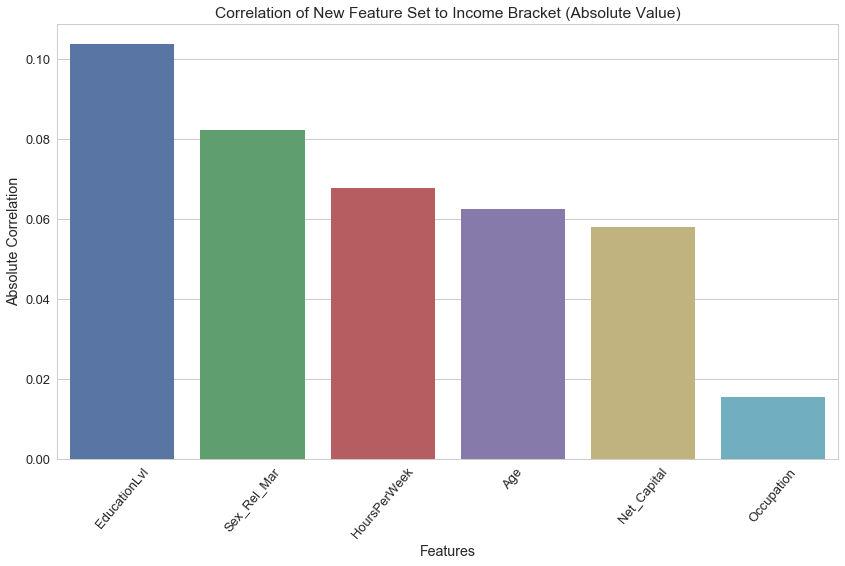

time: 363 ms


In [26]:
#Verify New Feature Set Correlations
training_encoded_short['IncomeBracket'] = training_clean['IncomeBracket'].astype('object')
training_encoded_short2 = encode_data(training_encoded_short)
corr2 = training_encoded_short2.corr()

#Plot Absolute Correlation Values for Each Feature
abs_corr2 = abs(corr2.iloc[0:6,6:7]).sort_values(by=['IncomeBracket'], ascending=False)

#Create Bar Plot of Feature Correlation Values
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(14,8))
bplot = sns.barplot(x=abs_corr2.index, y = 'IncomeBracket',  data=abs_corr2)
bplot.set(xlabel='Features', ylabel='Absolute Correlation')
bplot.set_title('Correlation of New Feature Set to Income Bracket (Absolute Value)')

#Rotate X-Tick Labels
for item in bplot.get_xticklabels():
    item.set_rotation(50) 

<u>Discussion</u>

The feature set has been reduced to six features by combinng correlated features. The features that did not have a strong impact were also removed from the set. Obseravtion of the new feature set correlations reveal that the new features are still apropriate (they have significant impact). However, the occupation value still lags the other features in impact. I will keep occupation in the mix because intuitively it is reasonable to link occpation to income levels. It is also a significant feature according to the MIC Value Method conducted above. 

## 4. Model Implementation

I will choose the following 4 classification algorithms,<br>
<ol>
    <li>k-Nearest Neighbour (kNN)</li>
    <li>Logistic Regression (LR)</li>
    <li>XGBoost (XGB) </li>
    <li>Random Forest (RF) </li>
</ol>

The encoded training data will be split into a feature space and target space (Income Bracket). A stratified 10-Fold will be applied to the data. A stratification fold arranges the data so that it is a good representation of the whole by preserving the percentage of data in each class. It wil perform a typical rotation data partitioning whereby producing ten different sets of samples from the population that will be used for training. This method is generally considered better to use in terms of bias and variance over the standrd k-fold method. Cross validation is used 


Comparison of the algoritms will be done based on the accuracy of each algorithm.

In [27]:
#Set up Feature & Target Sets from Training Data
feature_space = training_encoded_short2.iloc[:,:-1]
target_space = training_encoded_short2.iloc[:,6]

#Set up Feature & Target Sets from Testing Data
testing_encoded_short['IncomeBracket'] = testing_clean['IncomeBracket'].astype('object')
testing_encoded_short2 = encode_data(testing_encoded_short)
feature_space_test = testing_encoded_short2.iloc[:,:-1]
target_space_test = testing_encoded_short2.iloc[:,6]

#Prepare Stratified Folds
cv_data = StratifiedKFold(target_space, n_folds=10, shuffle=False, random_state=5)

time: 32 ms


#### 1. k-Nearest Neighbour

Discuss what it does and its pros/cons and why I choose this algorithm

K-Nearest Neighbours is a lazy learning classification algorithm which classifies a sample by comparing it to a number, k, nearest nieghbours. It computes the distance between all the features in the set and uses it to classifies test samples. The class of the sample is determined based on the highest number of similar neighbours based on the number of neighbours choosen to look at. It is important to choose a proper k or else the algoithm may misclassify the test sample if k is too large. 

Pros: Handles multi class cases, easy to implement, easily tuned with flexible distances, non-parametric<br>
Cons: Can be costly if the training set is very large. 

I choose this algorithm because it is used very commonly in practice and generally produces good results.

In [28]:
#Initialize the KNN Model (Default)
KNN = neighbors.KNeighborsClassifier()

#Train & Test kNN Model Using 10-Fold Train/Test Data
scores = []
for train_index, test_index in tqdm(cv_data):
        kNN_Model = KNN.fit(feature_space.iloc[train_index], target_space.iloc[train_index])
        scores.append(kNN_Model.score(feature_space.iloc[test_index], target_space.iloc[test_index]))
        
#Display Scores in Dataframe
scores = pd.DataFrame([scores], index = ['Score']).rename_axis('Fold', axis='columns')
average = scores.mean(axis=1)
variance = scores.var(axis=1)
scores['Average'] = average
scores['Variance'] = variance
scores['Std. Dev.'] = math.sqrt(variance)
scores


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Fold,0,1,2,3,4,5,6,7,8,9,Average,Variance,Std. Dev.
Score,0.766652,0.77361,0.772727,0.772286,0.775375,0.778464,0.767329,0.769435,0.768993,0.784452,0.772932,0.00003,0.005465


time: 5.98 s


Results: Average Accuracy = 77.29%, Variance = 0.00003, Std. Dev. = 0.005465

#### 2. Logisitc Regression

Logisitc regression is another very common classification algorithm. It uses the logit function probability scores to measure the relationship between a categorical dependent variable and one or more independanet variables.   

Pros: Independent variables can be categorical, does not need to be normally distributed data
Cons: Requires a large sample size

I chose this algorithm to compare to kNN because they both are the most commonly used mahcine learning methods and knowing the accuracy of each would be interesting. 

In [43]:
#Initialize the Model (Default)
LR = LogisticRegression()

#Train & Test Model Using 10-Fold Train/Test Data
scores = []
for train_index, test_index in tqdm(cv_data):
        LR_Model = LR.fit(feature_space.iloc[train_index], target_space.iloc[train_index])
        scores.append(LR_Model.score(feature_space.iloc[test_index], target_space.iloc[test_index]))
        
#Display Scores in Dataframe
scores = pd.DataFrame([scores], index = ['Score']).rename_axis('Fold', axis='columns')
average = scores.mean(axis=1)
variance = scores.var(axis=1)
scores['Average'] = average
scores['Variance'] = variance
scores['Std. Dev.'] = math.sqrt(variance)
scores

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Fold,0,1,2,3,4,5,6,7,8,9,Average,Variance,Std. Dev.
Score,0.765329,0.763901,0.770962,0.769197,0.766108,0.77361,0.766004,0.768551,0.769435,0.780035,0.769313,0.000023,0.004751


time: 4.61 s


Results: Average Accuracy = 76.93%, Variance = 0.000023, Std. Dev. = 0.004751 

#### 3. XGBoost (Ensemble)

XGBoost uses gradient boosted decision tree algorithm to improve the speed and performance. It is another ensemble technique that adds models to correct for errors from previous models. Gradient boosting is used to predict residuals of errors of previous models and adjusts the final prediction.  

Pros: Faster then just gradient boosting

In [95]:
#Initialize the Model (Default)
XGB = XGBClassifier()

#Train & Test Model Using 10-Fold Train/Test Data
scores = []
for train_index, test_index in tqdm(cv_data):
        XGB_Model = XGB.fit(feature_space.iloc[train_index], target_space.iloc[train_index])
        scores.append(XGB_Model.score(feature_space.iloc[test_index], target_space.iloc[test_index]))
        
#Display Scores in Dataframe
scores = pd.DataFrame([scores], index = ['Score']).rename_axis('Fold', axis='columns')
average = scores.mean(axis=1)
avg_xgb_train = average
variance = scores.var(axis=1)
scores['Average'] = average
scores['Variance'] = variance
scores['Std. Dev.'] = math.sqrt(variance)
scores

100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Fold,0,1,2,3,4,5,6,7,8,9,Average,Variance,Std. Dev.
Score,0.803705,0.806708,0.807149,0.805825,0.806267,0.80759,0.803091,0.801678,0.806095,0.806979,0.805509,0.000004,0.001984


time: 27.2 s


Results: Average Accuracy = 80.55%, Variance = 0.000004, Std. Dev. = 0.001984 

In [88]:
#Run on Test Data Set
test_pred = XGB_Model.predict(feature_space_test)
accuracy_score(target_space_test, test_pred)

0.79419828424869554

time: 158 ms


#### 4. Random Forest (Ensemble)

The Random Forest method is an ensemble learning method the creates multiple decision trees for training and uses the mode for classification of the individual trees. The purpose of random forest is to overcome overfitting during training which occurs in a single decision tree. This method uses full decision tree's so it has low bias but high variance, it attempts to reduce variance by using the mode of a collection of random tree's.

Pros: Very fast and scalable, reduces variance over single decision tree<br>
Cons: Accuracy of individual trees must be high to have a god result

I chose this algorithm to compare to the XGBoost algorithm which uses decision trees as it's basis. I expect the XGBoost to be an improvement over random forest. 

In [45]:
#Initialize the Model (Default)
RF = RandomForestClassifier()

#Train & Test Model Using 10-Fold Train/Test Data
scores = []
for train_index, test_index in tqdm(cv_data):
        RF_Model = RF.fit(feature_space.iloc[train_index], target_space.iloc[train_index])
        scores.append(RF_Model.score(feature_space.iloc[test_index], target_space.iloc[test_index]))
        
#Display Scores in Dataframe
scores = pd.DataFrame([scores], index = ['Score']).rename_axis('Fold', axis='columns')
average = scores.mean(axis=1)
variance = scores.var(axis=1)
scores['Average'] = average
scores['Variance'] = variance
scores['Std. Dev.'] = math.sqrt(variance)
scores

100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Fold,0,1,2,3,4,5,6,7,8,9,Average,Variance,Std. Dev.
Score,0.757389,0.759929,0.760812,0.768314,0.76346,0.762577,0.766887,0.765459,0.767668,0.757067,0.762956,0.000017,0.004116


time: 2.14 s


Results: Average Accuracy = 76.06%, Variance = 0.000039, Std. Dev. = 0.004116 

#### 5. Decision Tree Classifier (Extra)

In [17]:
#Initialize the Model (Default)
DT = DecisionTreeClassifier()

#Train & Test Model Using 10-Fold Train/Test Data
scores = []
for train_index, test_index in tqdm(cv_data):
        DT_Model = DT.fit(feature_space.iloc[train_index], target_space.iloc[train_index])
        scores.append(DT_Model.score(feature_space.iloc[test_index], target_space.iloc[test_index]))
        
#Display Scores in Dataframe
scores = pd.DataFrame([scores], index = ['Score']).rename_axis('Fold', axis='columns')
average = scores.mean(axis=1)
variance = scores.var(axis=1)
scores['Average'] = average
scores['Variance'] = variance
scores['Std. Dev.'] = math.sqrt(variance)
scores

100%|██████████| 10/10 [00:00<00:00, 17.00it/s]


Fold,0,1,2,3,4,5,6,7,8,9,Average,Variance,Std. Dev.
Score,0.731804,0.733451,0.725508,0.738747,0.72639,0.724184,0.739514,0.737191,0.741608,0.727032,0.732543,0.000042,0.006496


time: 640 ms


Results: Average Accuracy = 73.35%, Variance = 0.000047, Std. Dev. = 0.006507

<u>Discussion</u>

All the models performed quite well using the ten-fold training method.  The lowest score was 73% for the Decision Tree classifier and the highest score was the XGBoost algorithm at 80.5%. Not only did it have the best accuracy, the XGBoost algorithm also had the lowest standard deviation among all five algorithms implemented above. <br>

Unsurpirsingly, the XGBoost algorithm performed the slowest among all methods as it is most computationally intensive. The fastest method was Decision Trees followed closely by Random Forest (being an extension of Decision Trees).

Bias-Variance Trade-off....

Compare the model performance based on variance and mean score... which is the best and why do I think so.

## 5. Model Tuning

Model Tuning is conducted on each of the algorithms above to try and improve the score. Grid search is used to detremine the final optimal parameters and model.


#### 1. k-Nearest Neighbours Parameter Tuning

kNN has a few parameters that can be tuned including the number of neighbours 'k', the distance metric used between samples, the leaf size, the distance weights and algorithm used to determine the nearest neighbour.

In [28]:
#Initialize the KNN Model (Default)
KNN = neighbors.KNeighborsClassifier()

#Hyper Parameters Set
params = {'n_neighbors':np.arange(1,30)}

#Prepare Grid & Fit
KNN_Grid = GridSearchCV(KNN, param_grid=params, cv=10, n_jobs=-1, scoring='accuracy')
KNN_Tune = KNN_Grid.fit(feature_space, target_space)
print('Greatest Accuracy: ', KNN_Tune.best_score_, 'Optimal Parameter K: ', KNN_Tune.best_estimator_.n_neighbors)

Greatest Accuracy:  0.793193255054 Optimal Parameter K:  24
time: 5min 23s


Results: Best Accuracy = 0.7931, Time = 5min 23s, Optimal Parameter = 24

#### 2. Logistic Regression Parameter Tuning

The parameter C is tuned in Logisitc Regression.

In [30]:
#Initialize the Model (Default)
LR = LogisticRegression()

#Hyper Parameters Set
params = {'C':np.arange(0.001, 30, 0.1)}

#Prepare Grid & Fit
LR_Grid = GridSearchCV(LR, param_grid=params, cv=10, n_jobs=-1, scoring='accuracy')
LR_Tune = LR_Grid.fit(feature_space.iloc[train_index], target_space.iloc[train_index])
print('Greatest Accuracy: ', LR_Tune.best_score_, 'Optimal Parameter C: ', LR_Tune.best_estimator_.C)

Greatest Accuracy:  0.768759195684 Optimal Parameter C:  22.201
time: 15min 19s


Results: Best Accuracy = 0.7687, Time = 15min 19s, Optimal Parameter = 22.201

#### 3. XGBoost Parameter Tuning

The tuning parameters for XGBoost is the number of iterators and depth.

In [108]:
#Initialize the Model (Default)
XGB = XGBClassifier()

#Hyper Parameters Set
#params = {'n_estimators':np.arange(100, 300), 'max_depth':np.arange(1, 5)}
params = {'max_depth':np.arange(3, 8)}

#Prepare Grid & Fit
XGB_Grid = GridSearchCV(XGB, param_grid=params, cv=10, n_jobs=-1, scoring='accuracy')
XGB_Tune = XGB_Grid.fit(feature_space.iloc[train_index], target_space.iloc[train_index])
print('Greatest Accuracy: ', XGB_Tune.best_score_, 'Optimal Parameter n_est: ', XGB_Tune.best_estimator_.n_estimators, 'Optimal Parameter Depth: ', XGB_Tune.best_estimator_.max_depth)

Greatest Accuracy:  0.808239333006 Optimal Parameter n_est:  100 Optimal Parameter Depth:  6
time: 1min 55s


Results: Best Accuracy = 0.8082, Time = 18min 19s, Optimal Parameter = 100, Depth = 5

#### 4. Random Forest Parameter Tuning

The tuning parameter of the Random Forest method is the depth of the forest.

In [114]:
#Initialize the Model (Default)
RF = RandomForestClassifier()

#Set Tuning Parameter
#params = {'max_depth':np.linspace(2, 1, 100)}
params = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

#Create Grid
RF_Grid = GridSearchCV(RF, param_grid=params, cv=10, n_jobs=-1)
RF_Tune = RF_Grid.fit(feature_space, target_space)

print('Highest Accuracy: ', RF_Tune.best_score_, 'Best Depth: ', RF_Tune.best_estimator_.max_depth, 'Best Estimators: ', RF_Tune.best_estimator_.n_estimators)

Highest Accuracy:  0.802595568112 Best Depth:  10 Best Estimators:  9
time: 3min 56s


Results: Best Accuracy = 0.8024, Time = 4min 1s, Optimal Depth = 10, Estimators = 9

#### 5. Decision Tree Parameter Tuning

In [24]:
#Initialize the Model (Default)
DT = DecisionTreeClassifier()

#Set Tuning Parameter
params = {'max_depth':np.arange(3, 8), 'min_samples_leaf':np.arange(300, 350)}

#Create Grid
DT_Grid = GridSearchCV(DT, param_grid=params, cv=10, n_jobs=-1)

#Train & Test Model Using 10-Fold Train/Test Data
DT_Tune = DT_Grid.fit(feature_space, target_space)

print('Highest Accuracy: ', DT_Tune.best_score_)
print('Best Depth: ', DT_Tune.best_estimator_.max_depth)
print('Best Samples: ', DT_Tune.best_estimator_.min_samples_leaf)

Highest Accuracy:  0.790941996998
Best Depth:  4
Best Samples:  323
time: 32.9 s


Results: Best Accuracy = 0.7909, Time = 1 min 8s, Optimal Depth = 4, Optimal Samples Leaf: 323

## 6. Testing & Discussion

The model with the highest accuracy based on the tuned models is used to classify the testing data set. The accuracy of the model on the testing data is presented to validate the model. 

The Tuned XGB model had the best accuracy at 80% with the trained model. A new model is created with the optimal tuned parameters and it is applied to the testing set to predict the targets. 

In [124]:
#Set Up Model with Optimal Parameters
XGB2 = XGBClassifier(n_estimators = 100, max_depth = 5)

#Train The Model Again with Optimal Parameters
XGB_Model_Tuned = XGB2.fit(feature_space, target_space)

#Predict Targets from Testing Data Feature Space
XGB_Tune_Predic_Test = XGB_Model_Tuned.predict(feature_space_test)

#Score the Models Performance
xgb_test_score = accuracy_score(target_space_test, XGB_Tune_Predic_Test)
print('Test-Set Accuracy: Score   ', xgb_test_score, '\nTraining Accuracy:', XGB_Tune.best_score_)

Test-Set Accuracy: Score    0.796674626338 
Training Accuracy: 0.808239333006
time: 6 s


Results: Accuracy = 0.7966, Time = 4.51s

<module 'matplotlib.pyplot' from 'C:\\Users\\Hello\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

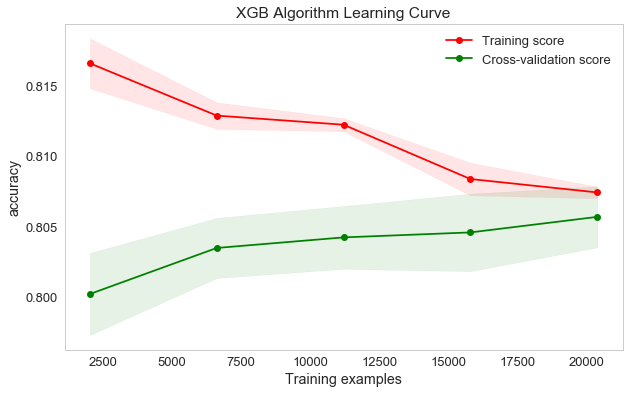

time: 1min 19s


In [169]:
#Learning Curve of Model 
plot_learning_curve(XGB_Model_Tuned, 'XGB Algorithm Learning Curve', feature_space, target_space, cv=10)

In [123]:
#Check Randome Forest Method for Comparison
#Set Up Model with Optimal Parameters
RF2 = RandomForestClassifier(n_estimators = 9, max_depth = 10 )

#Train The Model Again with Optimal Parameters
RF_Model_Tuned = RF2.fit(feature_space, target_space)

#Predict Targets 
RF_Tune_Predic_Test = RF_Model_Tuned.predict(feature_space_test)

#Score the Models Performance
rf_test_score = accuracy_score(target_space_test, RF_Tune_Predic_Test)
print('Test-Set Accuracy: Score   ', rf_test_score, '\nTraining Accuracy:', RF_Tune.best_score_)

Test-Set Accuracy: Score    0.79092597506 
Training Accuracy: 0.802595568112
time: 175 ms


#### Discussion

The outcome of the best model with the testing data is 79.8%. This is right inline with the accuracy of the model with the training set, 80.6%, which is a good outcome. Any discrepancy would be caused by overfitting of the training data during training, so I expect this accuracy to be lower. 

Before the model is tuned, the testing data had an accuracy of 79%. Using the tuned model improved the performance a small amount, by approximately 1%. Much better improvements after tuning can be see with other methods, most notably with Random Forest which had an improvement ofa bout 4%. The tuned random forest was the second best mondel at 80.2%. I also ran this model to predict the test data outcome and found its performance to be equivalent accuracy of 79.2%. 

The learning curve of the tuned XGB model provides insight into the bias-variance trade-off. The learning cuvre shows a high degree if sepration between the training score and cross-validation score which indicates a higher variance which in turns indicates a lower bias. The chart reveals that some overfitting is occuring and either more training data should be used or the paramters adjusted again to reduce the depth. I decreased the the maximum depth from 5 to 3 in the XGB which reduced the accuracy by a very marginal amount, less then 1% to 79.3% from 79.6%, but it decreased the variance in the model signifcantly producing a more bias. 

Generlly, the XGBoost training model reduced accuracy with more samples but this reduced variance in the model. Since the training curve and testing curve appear to be leveling out around 20,000 samples, it gives us a good idea that the model has learned all that it can from the data. A high-variance model is bad and a high bias model is bad so it is important to find the right balance of both in the model. The goal is to generalize the data, so a training curve and testing curve that plateau around the same time near each other is ideal. In this case, the XGB curves do level off at approxiamtely 80% accuracy mark which is an acceptaple fit. 

Another way to reduce the variance of the model could be to reduce the complexity of the features or remove some features altogether. I removed the two variables created above and focused on 4 variables from the original set. In this case, the model did not improve in accuracy, ir reduced by 5%, but the variance was reduced dramatically. Although this was a desirable goal, the resulting model is also not acceptable due to the very hig bias in the system now. Based on the scree plot in the feature engineering section above, we should have at least 5-6 features. This reduced model only has 3 features and this is indicative through the high bias which is reached early on in the training.

In [170]:
#Reduce Feature Set Test
feature_space_red = feature_space_test.iloc[:,:-2]

#Set Up Model with Optimal Parameters
XGB2 = XGBClassifier(n_estimators = 100, max_depth = 3)

#Train The Model Again with Optimal Parameters
XGB_Model_Tuned = XGB2.fit( feature_space_red, target_space_test )

#Predict Targets from Testing Data Feature Space
XGB_Tune_Predic_Test = XGB_Model_Tuned.predict( feature_space_red )

#Score the Models Performance
xgb_test_score2 = accuracy_score(target_space_test, XGB_Tune_Predic_Test)
print('Test-Set Accuracy: Score   ', xgb_test_score2, '\nTraining Accuracy:', XGB_Tune.best_score_)

Test-Set Accuracy: Score    0.75899885027 
Training Accuracy: 0.808239333006
time: 1.27 s


<module 'matplotlib.pyplot' from 'C:\\Users\\Hello\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

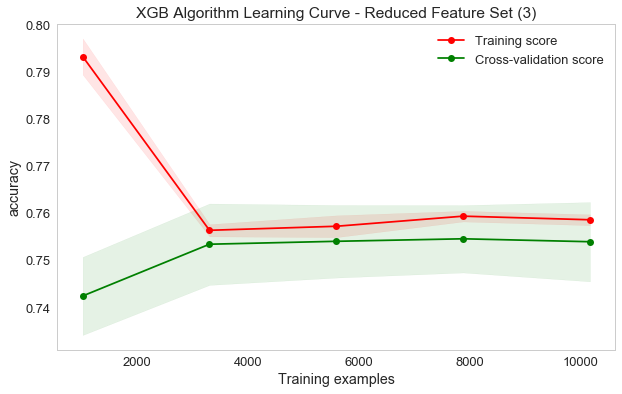

time: 32.1 s


In [171]:
#Learning Curve of Model of XGB with Reduced Feature Set
plot_learning_curve(XGB_Model_Tuned, 'XGB Algorithm Learning Curve - Reduced Feature Set (3)', feature_space_red, target_space_test, cv=10)

#### Overall Conclusions

A properly tuned XGBoost algorithm is well known to have one of the best results and is confirmed through this analysis. This assignment was very insightful in learning how to tune different algorithms and how to compare there performances. 